# Bootstrap analysis

### Objective:
Test whether consensus and expert annotations function similarly well as "ground truth" to tune a spot calling algorithm. Get a sense of the minimum "ground truth" annotations needed to effectively tune a spot calling algorithm.

### Test image:
ISS_rnd0_ch1_z0.png

### Takeaways:

It seems that the expert annotations and the consensus annotations performed similarly. This is not surprising, because precision and recall of the consensus annotations based on expert annotations were both pretty good. For this chemistry (RCA), it seems that about 15 or 20 “ground truth” annotations were needed in order to assure sufficient coverage across the range of spot sizes and intensities and thus get reliable spot parameters. Above 15 or 20 “ground truth” annotations, using more sample spots did not significantly improve precision and recall. 

In [1]:
import pandas as pd
import numpy as np
import sys, os, warnings

from fishanno import QuantiusAnnotation, SpotAnnotationAnalysis, param

from starfish import data, FieldOfView
from starfish.image import Filter
from starfish.spots import DetectSpots
from starfish.types import Axes

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from skimage.io import imread

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.12.2. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [39]:
num_iter = 10
test_thresholds = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
num_spots_list = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

test_img_filenames = ['ISS_rnd0_ch1_z0']
round_channel = [(0, 1)]
origins = ['expert', 'consensus']

margin = 4
correctness_threshold = 10

In [4]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.ISS(use_test_data=use_test_data)
fov = experiment.fov()
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)

100%|██████████| 16/16 [00:00<00:00, 16.08it/s]


In [5]:
# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
filtered_imgs = filt.run(imgs, verbose=True, in_place=False)

16it [00:15,  2.02s/it]


In [40]:
if not os.path.exists('./bootstrap_data/'):
    os.mkdir('./bootstrap_data/')

In [73]:
for ind, test_img_filename in enumerate(test_img_filenames):
    
#     print('\n\ntest_img_filename = ' + test_img_filename)
    round_ind, channel_ind = round_channel[ind]
    round_ind, channel_ind = (0, 1)

    test_img_path = './test_images_filtered/images/%s.png' % test_img_filename
    im = imread(test_img_path, as_gray=True)
    img_height = len(im)

    expert_path = './test_images_filtered/coords/%s.csv' % test_img_filename
    consensus_path = './consensus/%s/total.csv' % test_img_filename

    expert_coords = np.asarray(pd.read_csv(expert_path))
    consensus_coords = np.asarray(pd.read_csv(consensus_path))

    # slice the ImageStack
    sel={Axes.ROUND: round_ind, Axes.CH: channel_ind, Axes.ZPLANE: 0}
    single_plane_filtered = filtered_imgs.sel(sel)

    for origin in origins:
    
#         print('origin = ' + origin)

        coords = expert_coords if origin=='expert' else consensus_coords
        num_spots_total = len(coords)
        precision_mean_list, precision_std_list, recall_mean_list, recall_std_list = [], [], [], []
        
#        for fraction in fraction_list:
        for num_spots_sample in num_spots_list:
            
#             print('num_spots_sample = ' + str(num_spots_sample))

#             num_spots_sample = int(fraction * num_spots_total)
            precision_of_blobs_list, recall_of_blobs_list, best_thresholds_list = [], [], []

            for n in range(num_iter):
                
#                 print('n = ' + str(n))
                
                # sample fraction of coords
                idx = np.random.randint(num_spots_total, size=num_spots_sample)
                sample_coords = coords[idx,:]

                # extract params from sample
                sigma_list = param.get_sigma_list(test_img_path, sample_coords, margin)
                if not sigma_list:
                    continue

#                 print(len(expert_coords), min(sigma_list), max(sigma_list))
                
                    # calc precision and recall (based on total expert)
                ref_coords = np.asarray(pd.read_csv(expert_path))
                    
                best_threshold, best_recall, best_precision, recall_list, precision_list = param.get_best_threshold(
                    ref_coords, test_img_path, min(sigma_list), max(sigma_list), correctness_threshold, test_thresholds)
                                
#                 plt.figure(figsize = (6, 3))
#                 plt.scatter(recall_list, precision_list, c='#d8b365')
#                 plt.scatter(recall_list[0], precision_list[0], c='red')
#                 plt.scatter([best_recall], [best_precision], c='#5ab4ac')
#                 plt.xlabel('Recall')
#                 plt.ylabel('Precision')

#                 handle1 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#d8b365', label='test thresholds')
#                 handle2 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#5ab4ac', label='optimal threshold')
#                 plt.legend(handles=[handle1, handle2], loc='lower left')

#                 plt.title('intensity threshold')
#                 plt.savefig('spot_intensity_hist.pdf', transparent=True, bbox_inches="tight")
#                 plt.show()
                
                # spot calling using params
                p = DetectSpots.BlobDetector(
                    min_sigma=min(sigma_list),
                    max_sigma=max(sigma_list),
                    num_sigma=10,
                    threshold=best_threshold,
                    measurement_type='mean',
                )
                new_stack = single_plane_filtered.from_numpy(single_plane_filtered.xarray.values) 
                intensities = p.run(new_stack)
                spots = intensities[:, 0, 0].where(intensities[:, 0, 0] != 0, drop=True)
                x_vals = spots.x.values
                if len(x_vals)==0:
                    continue
                y_vals = spots.y.values

                blobs = []
                for x, y in zip(x_vals, y_vals):
                    blobs.append([x, y])
                blobs = np.asarray(blobs)
                
                # calc precision and recall (based on total expert)
                ref_coords = np.asarray(pd.read_csv(expert_path))
                
#                 ####################
#                 plt.figure(figsize=(10,10))
#                 for x, y in blobs:
#                     plt.scatter([x], [y], edgecolor='cyan', facecolor='None')
#                 plt.imshow(im, cmap='gray')
#                 for x, y in ref_coords:
#                     plt.scatter([x], [y], edgecolor='yellow', facecolor='None')
#                 plt.show()
#                 ####################                
                
                precision, recall = param.get_precision_recall(test_coords=blobs, ref_coords=ref_coords, correctness_threshold=correctness_threshold)
                precision_of_blobs_list.append(precision)
                recall_of_blobs_list.append(recall)
                best_thresholds_list.append(best_threshold)
            
            path_a = './bootstrap_data/%s_%s_precisions_%s.csv' % (origin, test_img_filename, str(num_spots_sample))
            path_b = './bootstrap_data/%s_%s_recalls_%s.csv' % (origin, test_img_filename, str(num_spots_sample))
            path_c = './bootstrap_data/%s_%s_thresholds_%s.csv' % (origin, test_img_filename, str(num_spots_sample))
            np.savetxt(path_a, precision_of_blobs_list, delimiter=',')
            np.savetxt(path_b, recall_of_blobs_list, delimiter=',')
            np.savetxt(path_c, best_thresholds_list, delimiter=',')
            
            precision_mean_list.append(np.mean(precision_of_blobs_list))
            precision_std_list.append(np.std(precision_of_blobs_list))
            recall_mean_list.append(np.mean(recall_of_blobs_list))
            recall_std_list.append(np.std(recall_of_blobs_list))

        # save mean and std precision and recall lists
        path1 = './bootstrap_data/%s_%s_precision_means.csv' % (origin, test_img_filename)
        path2 = './bootstrap_data/%s_%s_precision_stds.csv' % (origin, test_img_filename)
        path3 = './bootstrap_data/%s_%s_recall_means.csv' % (origin, test_img_filename)
        path4 = './bootstrap_data/%s_%s_recall_stds.csv' % (origin, test_img_filename)
        np.savetxt(path1, precision_mean_list, delimiter=",")
        np.savetxt(path2, precision_std_list, delimiter=",")
        np.savetxt(path3, recall_mean_list, delimiter=",")
        np.savetxt(path4, recall_std_list, delimiter=",")

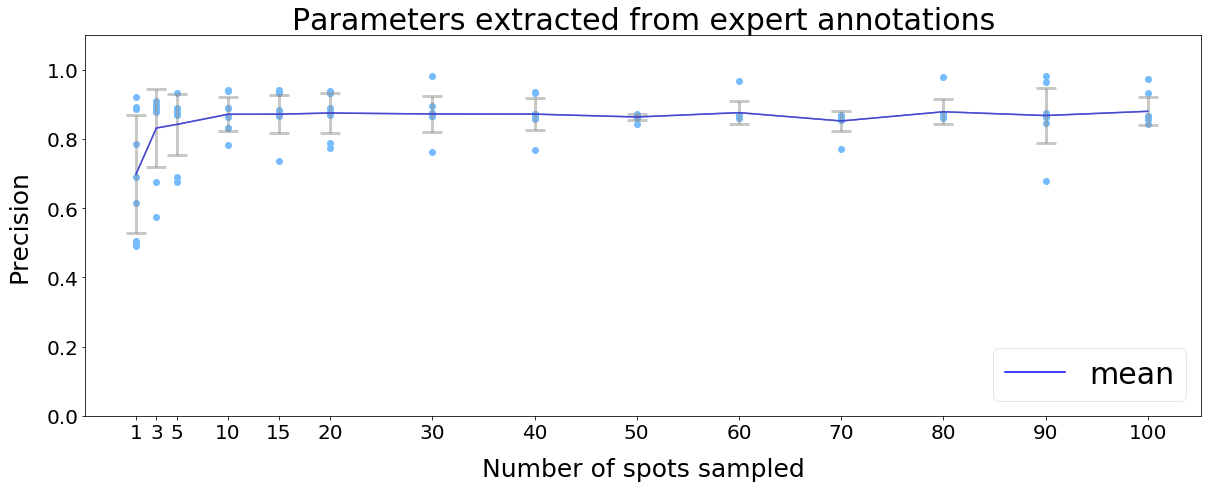

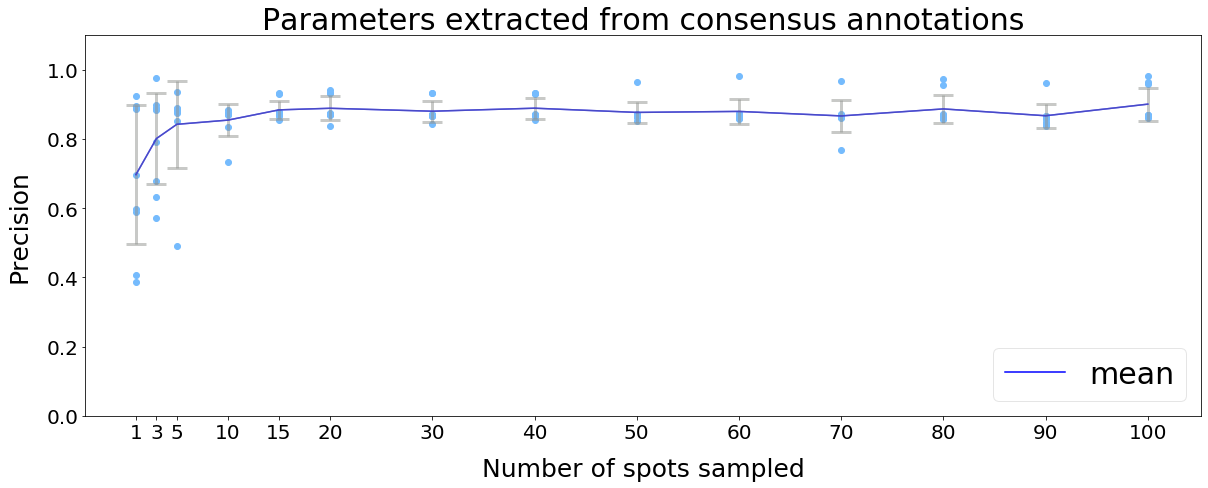

In [126]:
for test_img_filename in test_img_filenames:
    for origin in origins:
        plt.figure(figsize=(20,7))
        title = 'Parameters extracted from %s annotations' % origin
        plt.title(title, fontsize=30)
        precision_means, precision_stds = [], []
        for ind, num_spots_sample in enumerate(num_spots_list):
            
            precisions_path = './bootstrap_data/%s_%s_precisions_%s.csv' % (origin, test_img_filename, num_spots_sample)
            precisions = np.asarray(pd.read_csv(precisions_path))
            precision_means.append(np.mean(precisions))
            precision_stds.append(np.std(precisions))
            plt.scatter([num_spots_sample]*len(precisions), [precisions], c='xkcd:sky blue')
        
        (_, caps, _) = plt.errorbar(num_spots_list, precision_means, yerr=precision_stds, color='xkcd:gray', capsize=10, elinewidth=3, alpha=0.5)
        for cap in caps:
            cap.set_color('xkcd:gray')
            cap.set_markeredgewidth(3)
            
        plt.plot(num_spots_list, precision_means, color='b')
        plt.xlabel('Number of spots sampled', fontsize=25, labelpad=15)
        plt.ylabel('Precision', fontsize=25, labelpad=15)
        
        leg_elem_1 = Line2D([0], [0], marker='None', color='b', label='mean')
        handle_list = [leg_elem_1]
        plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':30}, framealpha=0.5)
        plt.xticks(num_spots_list, fontsize=20)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
        plt.ylim(0, 1.1)
        
        filename = "%s_%s_bootstrap_precision.pdf" % (test_img_filename, origin)
        plt.savefig(filename, transparent=True, bbox_inches="tight")
        plt.show()
        

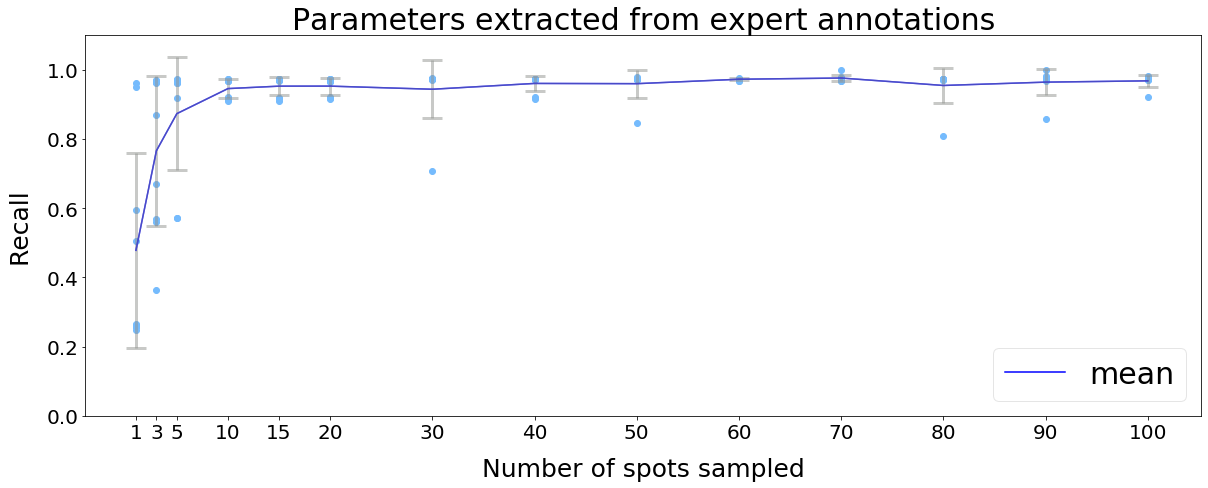

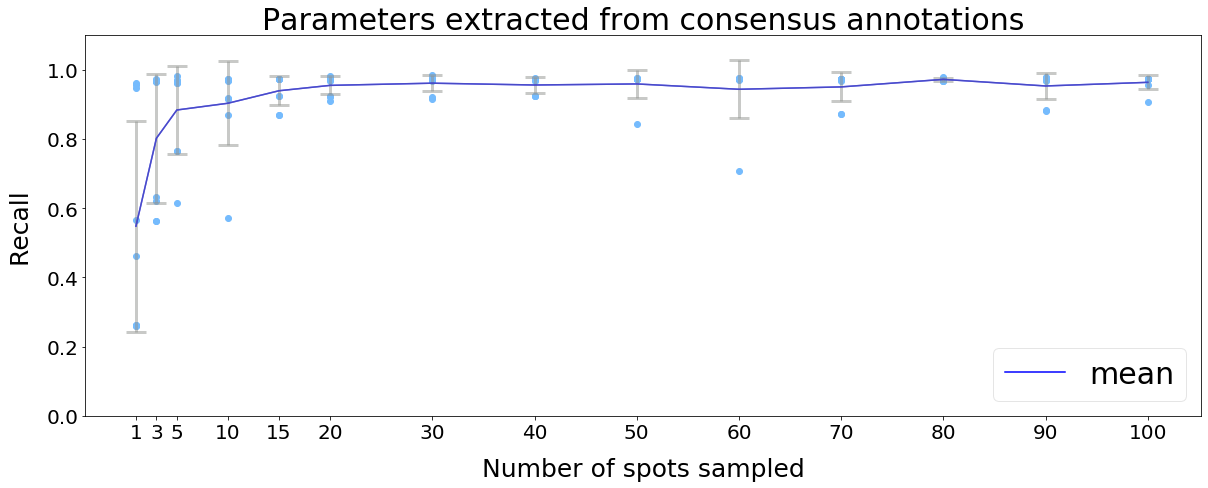

In [125]:
for test_img_filename in test_img_filenames:
    for origin in origins:
        plt.figure(figsize=(20,7))
        title = 'Parameters extracted from %s annotations' % origin
        plt.title(title, fontsize=30)
        recall_means, recall_stds = [], []
        for ind, num_spots_sample in enumerate(num_spots_list):
                        
            recalls_path = './bootstrap_data/%s_%s_recalls_%s.csv' % (origin, test_img_filename, num_spots_sample)
            recalls = np.asarray(pd.read_csv(recalls_path))
            
            recall_means.append(np.mean(recalls))
            recall_stds.append(np.std(recalls))
            plt.scatter([num_spots_sample]*len(recalls), [recalls], c='xkcd:sky blue')
        
        (_, caps, _) = plt.errorbar(num_spots_list, recall_means, yerr=recall_stds, color='xkcd:gray', capsize=10, elinewidth=3, alpha=0.5)
        for cap in caps:
            cap.set_color('xkcd:gray')
            cap.set_markeredgewidth(3)
            
        plt.plot(num_spots_list, recall_means, color='b')
        plt.xlabel('Number of spots sampled', fontsize=25, labelpad=15)
        plt.ylabel('Recall', fontsize=25, labelpad=15)
        
        leg_elem_1 = Line2D([0], [0], marker='None', color='b', label='mean')
        handle_list = [leg_elem_1]
        plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':30}, framealpha=0.5)
        plt.xticks(num_spots_list, fontsize=20)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
        plt.ylim(0, 1.1)
        
        filename = "%s_%s_bootstrap_recall.pdf" % (test_img_filename, origin)
        plt.savefig(filename, transparent=True, bbox_inches="tight")
        plt.show()
        